In [1]:
!pip install cyvcf2

In [2]:
from cyvcf2 import VCF
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parents[2] / "src" / "python"))
from paths import training_path
from vcf_helpers import normalize_vcf_features, extract_variant_features

In [3]:
vcf_path1 = "training.vcf"
vcf_path2 = "training_chr19.vcf"

In [4]:
# INFO and FORMAT fields to extract
info_fields = [
    "MBQ", "MMQ", "GOLDEN"
]

format_fields = [
    "AD", "AF", "F1R2", "F2R1"
]

split_ref_alt_fields = {"AD", "AF", "F1R2", "F2R1"}
split_info_ref_alt = {"MBQ", "MMQ"}

In [5]:
# Load VCF
vcf1 = VCF(vcf_path1)
sample_names1 = vcf1.samples
print(sample_names1)

['HG008-N', 'HG008-T']


In [6]:
# Load VCF
vcf2 = VCF(vcf_path2)
sample_names2 = vcf2.samples
print(sample_names2)

['chr19.tumor.snv.indel']


In [7]:
tumor_sample_index1 = determine_tumor_sample_index(sample_names1)
tumor_sample_index2 = determine_tumor_sample_index(sample_names2)

Using tumor sample: HG008-T
Using tumor sample: chr19.tumor.snv.indel


In [8]:
df1 = extract_variant_features(vcf1, info_fields, format_fields, split_info_ref_alt, split_ref_alt_fields, tumor_sample_index1)

            F2R1_alt       F1R2_alt         AD_alt             AF  \
count  107347.000000  107347.000000  107347.000000  107347.000000   
mean        5.564496       5.589714      13.963585       0.150086   
std        10.725993      10.693850      21.841646       0.219196   
min         0.000000       0.000000       0.000000       0.002559   
25%         1.000000       1.000000       4.000000       0.043000   
50%         2.000000       2.000000       6.000000       0.068000   
75%         4.000000       4.000000      12.000000       0.119000   
max       648.000000     534.000000    1338.000000       0.995000   

             MBQ_alt        MMQ_alt         AD_ref       F1R2_ref  \
count  107347.000000  107347.000000  107347.000000  107347.000000   
mean       29.408172      45.744017     111.041166      49.498151   
std        11.578353      15.559005     158.887318      75.785950   
min         0.000000      20.000000       0.000000       0.000000   
25%        19.000000      28.0000

In [9]:
df1["GOLDEN"] = df1["GOLDEN"].fillna(False).astype(int)
df1["GOLDEN"].value_counts()

/tmp/ipykernel_1589866/1363210350.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1["GOLDEN"] = df1["GOLDEN"].fillna(False).astype(int)


GOLDEN
0    98329
1     9018
Name: count, dtype: int64

In [10]:
df2 = extract_variant_features(vcf2, info_fields, format_fields, split_info_ref_alt, split_ref_alt_fields, tumor_sample_index2)

           F2R1_alt      F1R2_alt        AD_alt            AF       MBQ_alt  \
count  83268.000000  83268.000000  83268.000000  83268.000000  83268.000000   
mean       7.659329      7.665814     16.976041      0.622973     32.934212   
std        8.802908      8.642207     19.509347      0.250625      3.517557   
min        0.000000      0.000000      1.000000      0.006687      0.000000   
25%        4.000000      4.000000      9.000000      0.444000     33.000000   
50%        7.000000      7.000000     15.000000      0.552000     34.000000   
75%       10.000000     10.000000     22.000000      0.942000     35.000000   
max      665.000000    653.000000   1631.000000      0.993000     37.000000   

            MMQ_alt        AD_ref      F1R2_ref      F2R1_ref  
count  83268.000000  83268.000000  83268.000000  83268.000000  
mean      56.101311     10.976570      4.844718      4.867476  
std       10.020979     36.276465     14.530636     15.420934  
min       20.000000      0.00000

In [11]:
df2["GOLDEN"] = df2["GOLDEN"].fillna(False).astype(int)
df2["GOLDEN"].value_counts()

/tmp/ipykernel_1589866/2730846698.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2["GOLDEN"] = df2["GOLDEN"].fillna(False).astype(int)


GOLDEN
0    82192
1     1076
Name: count, dtype: int64

In [12]:
# Balance df1 to match df2
df2_counts = df2["GOLDEN"].value_counts()
target_0 = df2_counts.get(0, 0)
target_1 = df2_counts.get(1, 0)

df1_pos = df1[df1["GOLDEN"] == 1]
df1_neg = df1[df1["GOLDEN"] == 0]

df1_pos_down = df1_pos.sample(n=target_1, random_state=42)
df1_neg_down = df1_neg.sample(n=target_0, random_state=42)

df1_balanced = pd.concat([df1_pos_down, df1_neg_down], ignore_index=True).sample(frac=1.0, random_state=42)

In [13]:
df = pd.concat([df1_balanced, df2], ignore_index=True)

In [14]:
# --- Drop all-null columns ---
before_cols = set(df.columns)
df.dropna(axis=1, how="all", inplace=True)
after_null_cols = set(df.columns)
dropped_null_cols = sorted(list(before_cols - after_null_cols))

# --- Drop single-value columns (no variance) ---
protected_cols = {"CHROM"}  # Add other key columns here if needed
single_value_cols = [col for col in df.columns if col not in protected_cols and df[col].nunique(dropna=False) <= 1]
df.drop(columns=single_value_cols, inplace=True)

# Track dropped columns
dropped_columns = dropped_null_cols + single_value_cols

df["GOLDEN"] = df["GOLDEN"].fillna(False).astype(int)

df = normalize_vcf_features(df)

output_path = "vcf_feature_vectors.csv"
df.to_csv(output_path, index=False)
print(f"Saved cleaned, split, normalized features to: {output_path}")

if dropped_columns:
    print("\n Dropped empty or excluded columns:")
    for col in dropped_columns:
        print(f" - {col}")
else:
    print("\n No empty columns were removed.")

Saved cleaned, split, normalized features to: vcf_feature_vectors.csv

 No empty columns were removed.


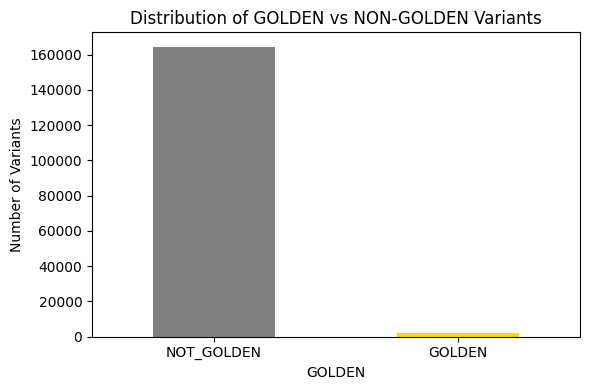

In [15]:
# Check if the 'GOLDEN' column exists, and treat it as a binary flag (1 if present, 0 otherwise)
if 'GOLDEN' in df.columns:
    golden_counts = df['GOLDEN'].fillna(0).astype(bool).value_counts().rename({True: 'GOLDEN', False: 'NOT_GOLDEN'})

    # Plot the distribution
    plt.figure(figsize=(6, 4))
    golden_counts.plot(kind='bar', color=['gray', 'gold'])
    plt.title("Distribution of GOLDEN vs NON-GOLDEN Variants")
    plt.ylabel("Number of Variants")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_violin_and_box(df, feature_groups):    
    for name, cols in feature_groups.items():
        cols = [col for col in cols if col in df.columns]
        if not cols:
            continue

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(len(cols) * 0.6 * 2, 5), sharey=True)

        # Box plot
        sns.boxplot(data=df[cols], ax=axes[0])
        axes[0].set_title(f"{name} Features - Boxplot")
        axes[0].tick_params(axis='x', rotation=45)

        # Violin plot
        sns.violinplot(data=df[cols], ax=axes[1])
        axes[1].set_title(f"{name} Features - Violinplot")
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

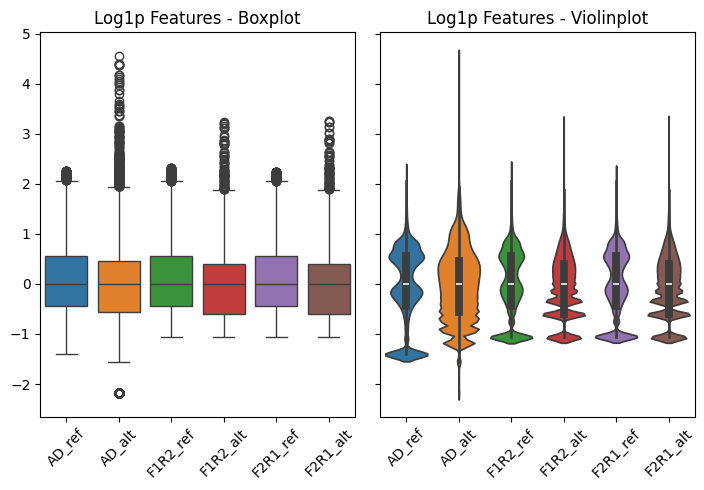

In [17]:
log1p_cols = [
    "DP", "AD_ref", "AD_alt", "FAD_ref", "FAD_alt",
    "F1R2_ref", "F1R2_alt", "F2R1_ref", "F2R1_alt",
    "SB_ref_fwd", "SB_ref_rev", "SB_alt_fwd", "SB_alt_rev",
    "AS_SB_ref_fwd", "AS_SB_ref_rev", "AS_SB_alt_fwd", "AS_SB_alt_rev"
]

plot_violin_and_box(df, {
    "Log1p": log1p_cols
})

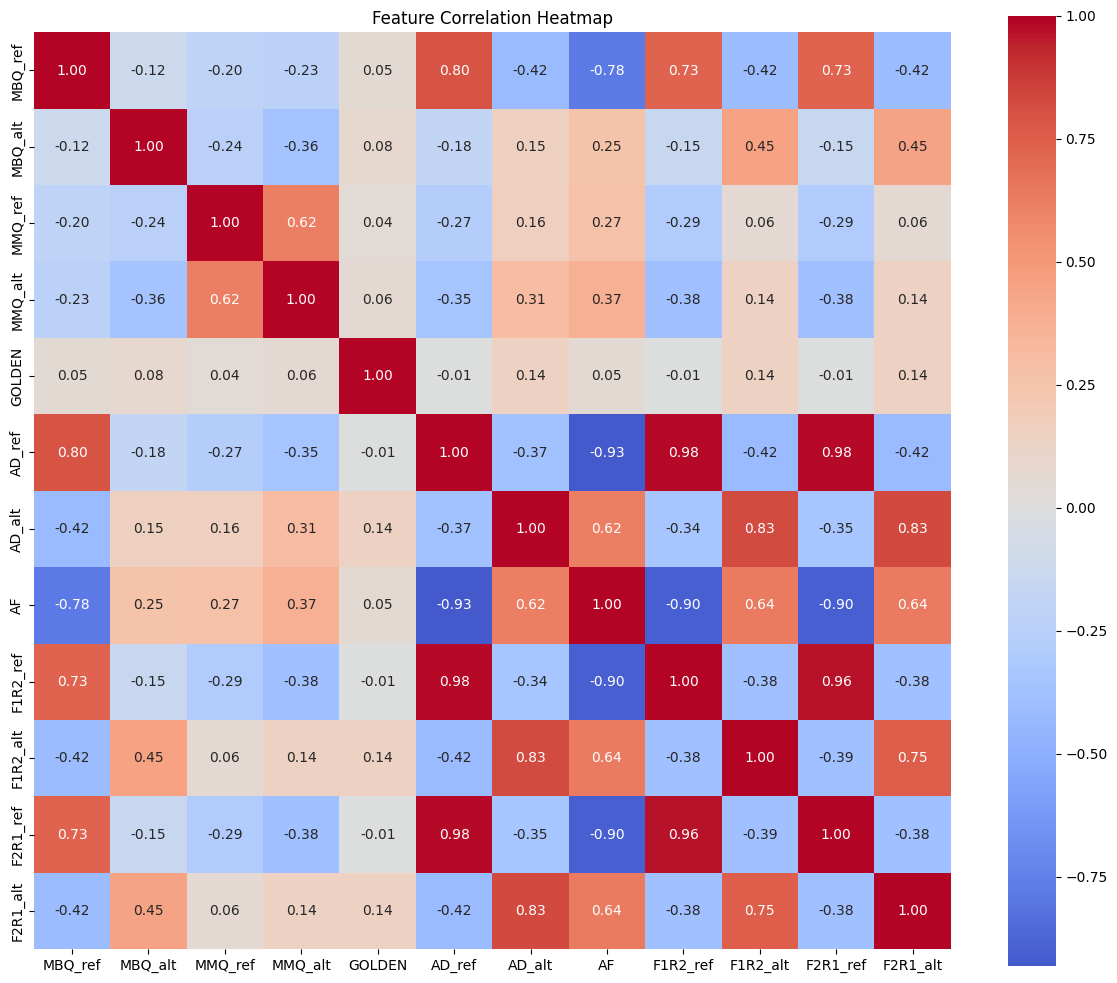

In [18]:
df_corr = df.drop(columns=["CHROM", "POS", "REF", "ALT"])
df_corr = df_corr.select_dtypes(include=[np.number])

corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

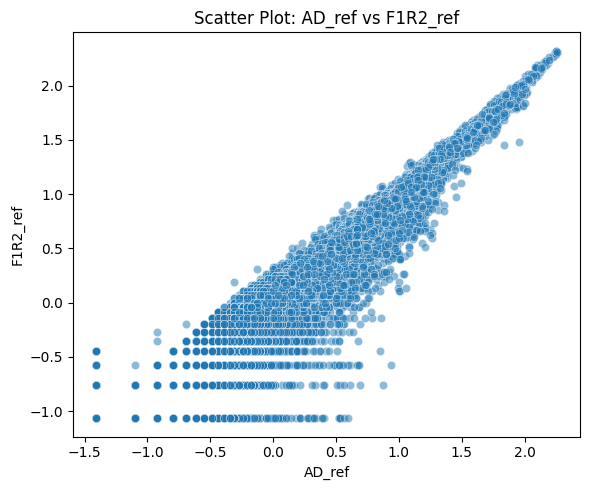

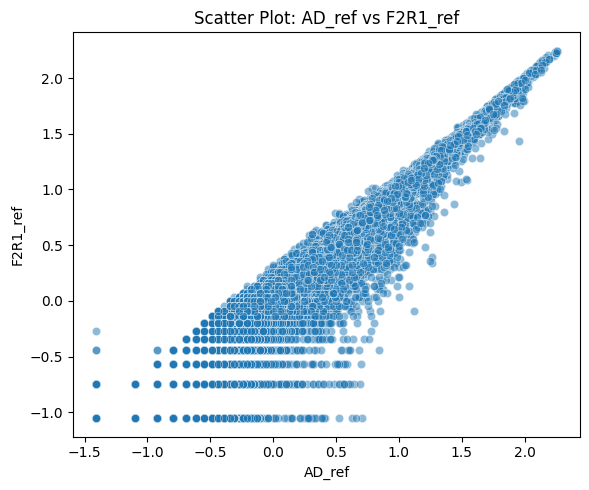

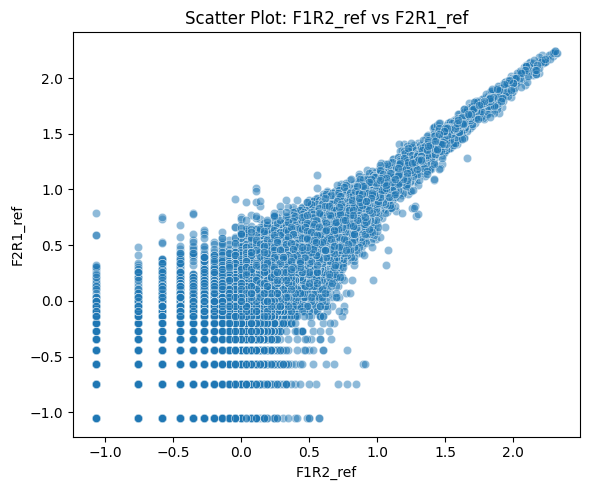

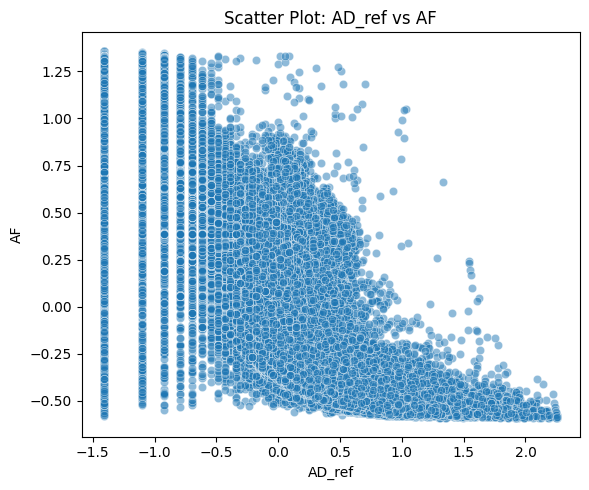

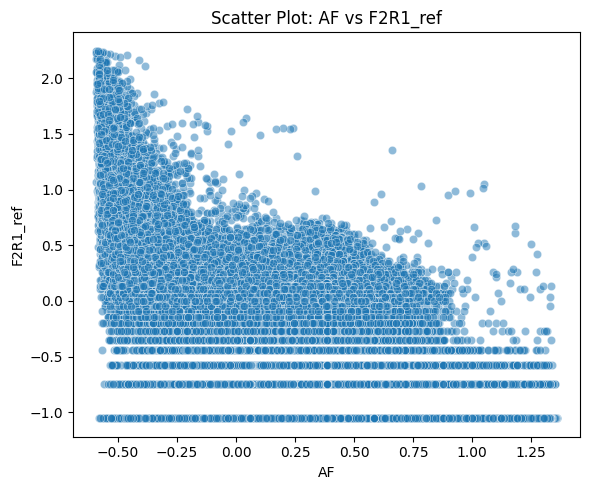

In [23]:
# Compute absolute correlation matrix and extract top pairs
corr_matrix_abs = corr_matrix.abs()
corr_pairs = (
    corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

# Show top 5 strongest correlations (excluding self-correlations)
top_pairs = corr_pairs.head(5).index.tolist()

for x, y in top_pairs:
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(f"Scatter Plot: {x} vs {y}")
    plt.tight_layout()
    plt.show()